In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [2]:
df = pd.read_excel("Time_Series_Data_Example.xlsx")

In [3]:
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")

In [4]:
train, test = df[:-364], df[-364:]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [6]:
look_back = 50
n_features = 1

generator = TimeseriesGenerator(train, train,
                                length = look_back,
                                sampling_rate = 1,
                                stride = 1,
                                batch_size = 3)

In [7]:
model = Sequential()
model.add(LSTM(units = 200, return_sequences = True, input_shape=(look_back, n_features)))
model.add(Dropout(0.15))


#Add second LSTM layer 
model.add(LSTM(units = 200, return_sequences = True))
model.add(Dropout(0.2))

#Add third LSTM layer 
model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.2))

#Add fourth LSTM layer 
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

#Add fifth LSTM layer 
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

#Add sixth LSTM layer 
model.add(LSTM(units = 25, return_sequences = True, activation='relu'))
model.add(Dropout(0.2))


#flatten
model.add(Flatten())


model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
%time

W1231 18:32:54.046345 17512 deprecation_wrapper.py:119] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1231 18:32:54.060344 17512 deprecation_wrapper.py:119] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1231 18:32:54.063346 17512 deprecation_wrapper.py:119] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1231 18:32:54.320347 17512 deprecation_wrapper.py:119] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

Wall time: 0 ns


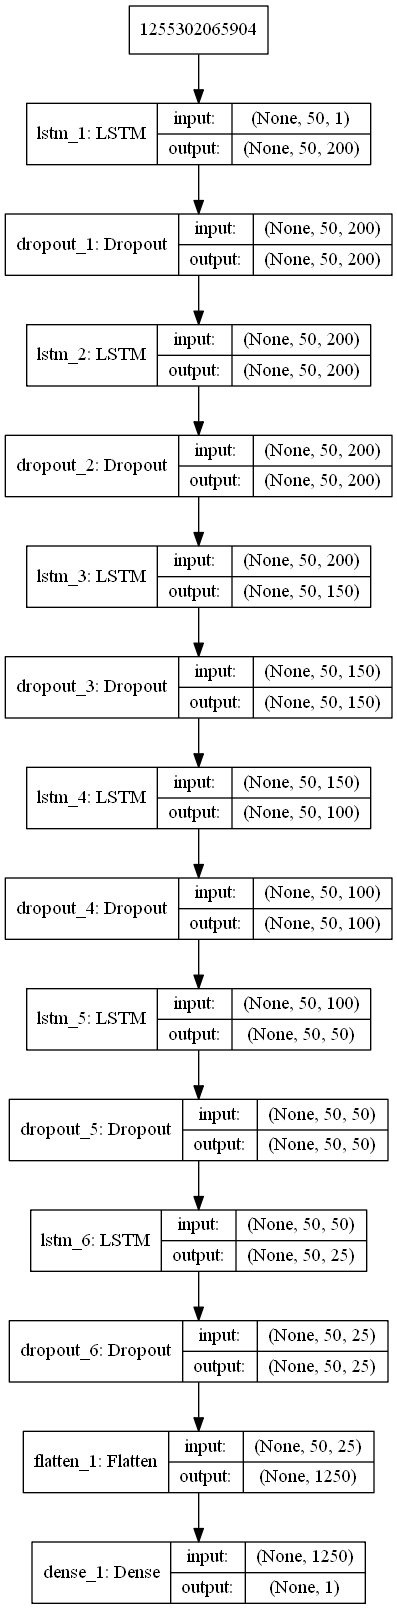

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [9]:
model.fit_generator(generator, epochs=100)
%time

W1231 18:32:56.475949 17512 deprecation.py:323] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1231 18:33:01.028908 17512 deprecation_wrapper.py:119] From C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
106/106 [==============================] - 70s 659ms/step - loss: 0.1287
Epoch 2/100
106/106 [==============================] - 67s 633ms/step - loss: 0.0944
Epoch 3/100
106/106 [==============================] - 68s 644ms/step - loss: 0.0945
Epoch 4/100
106/106 [==============================] - 70s 664ms/step - loss: 0.0318
Epoch 5/100
106/106 [==============================] - 76s 718ms/step - loss: 0.0192
Epoch 6/100
106/106 [==============================] - 58s 545ms/step - loss: 0.0121
Epoch 7/100
106/106 [==============================] - 56s 528ms/step - loss: 0.0079
Epoch 8/100
106/106 [==============================] - 53s 502ms/step - loss: 0.0075
Epoch 9/100
106/106 [==============================] - 52s 492ms/step - loss: 0.0065
Epoch 10/100
106/106 [==============================] - 53s 503ms/step - loss: 0.0064
Epoch 11/100
106/106 [==============================] - 53s 496ms/step - loss: 0.0051
Epoch 12/100
106/106 [==============================] - 53s 498

106/106 [==============================] - 54s 506ms/step - loss: 0.0013
Epoch 97/100
106/106 [==============================] - 62s 589ms/step - loss: 0.0011
Epoch 98/100
106/106 [==============================] - 65s 615ms/step - loss: 0.0010
Epoch 99/100
106/106 [==============================] - 66s 621ms/step - loss: 0.0014
Epoch 100/100
106/106 [==============================] - 68s 643ms/step - loss: 8.0114e-04
Wall time: 0 ns


In [10]:
model.save('longer_future.h')

In [11]:
from keras.models import load_model
model = load_model('longer_future.h')

In [12]:
model.evaluate_generator(generator)

0.0007347227898967906

In [13]:
trainPredict = model.predict_generator(generator)
trainPredict.shape

(316, 1)

In [14]:
trainPredict = scaler.inverse_transform(trainPredict)

In [15]:
train = scaler.inverse_transform(train)
train.shape

(366, 1)

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(train)

trainPredictPlot[:, :] = np.nan

trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict




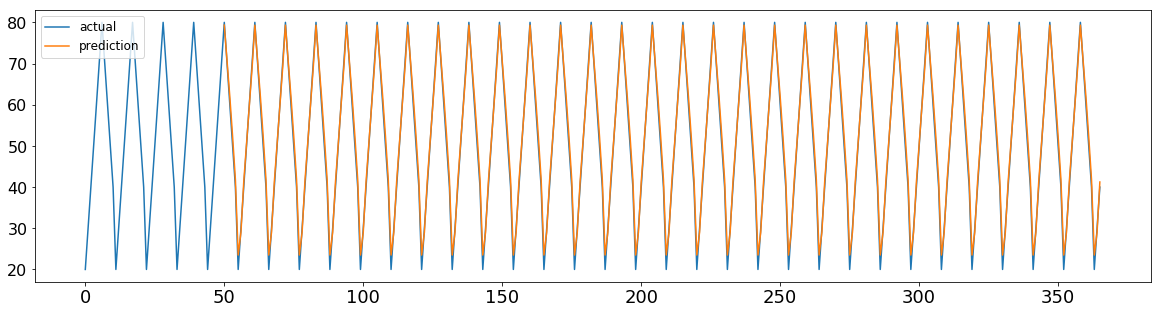

In [17]:
plt.figure(figsize=(20, 5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.plot(train, label="actual")
plt.plot(trainPredictPlot, label="prediction")
plt.legend(loc='best', fontsize='large')
plt.show()

In [18]:
train = df

In [19]:
scaler.fit(train)
train = scaler.transform(train)

In [20]:
look_forward = 50
n_features = 1

generator = TimeseriesGenerator(train, train,
                                length = look_forward,
                                sampling_rate = 1,
                                stride = 1,
                                batch_size = 3)

In [21]:
pred_list = []

batch = train[-look_forward:].reshape((1, look_forward, n_features))

for i in range(look_forward):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [24]:
from pandas.tseries.offsets import DateOffset

add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,51) ]

future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)

In [25]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-look_forward:].index, columns=['Prediction'])

df_proj = pd.concat([df, df_predict], axis=1)

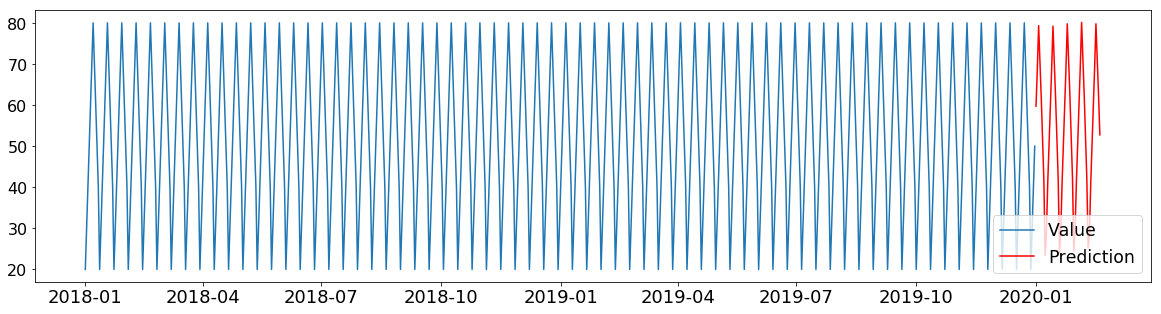

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Value'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()